<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(ClassicalOptimizer)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
!pip install qiskit-algorithms==0.3.1
!pip install qiskit-nature[pyscf]==0.7.2
!pip install pyscf==2.6.0

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""
VQE (Variational Quantum Eigensolver) 구현
수소 분자(H2)의 바닥 상태 에너지 계산
"""

import numpy as np
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA, NFT, P_BFGS, QNSPSA, P_BFGS, ADAM, adam_amsgrad, NELDER_MEAD, POWELL, TNC, CG, NFT, IMFIL, SNOBFIT, BOBYQA, GSLS, AQGD
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal
from qiskit_aer import AerSimulator

print("=" * 60)
print("VQE를 이용한 분자 에너지 계산")
print("=" * 60)

VQE를 이용한 분자 에너지 계산


In [ ]:
# 1. 분자 (구조)정의 (H2 분자)
print("\n[1단계] 분자 구조 정의")
print("-" * 60)

# 수소 분자 정의 (원자간 거리: 0.735 Angstrom)
molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.735"
driver = PySCFDriver(
    atom=molecule,
    basis="sto3g",  # 기저 함수
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

print(f"분자: H2 (수소 분자)")
print(f"원자간 거리: 0.735 Å")
print(f"기저 함수: STO-3G")


[1단계] 분자 구조 정의
------------------------------------------------------------
분자: H2 (수소 분자)
원자간 거리: 0.735 Å
기저 함수: STO-3G


In [ ]:
# 2. 전자 구조 문제 설정
print("\n[2단계] 전자 구조 문제 설정")
print("-" * 60)

problem = driver.run()
print(f"분자 궤도 개수: {problem.num_spatial_orbitals}")
print(f"전자 개수: {problem.num_particles}")

# Hamiltonian 얻기
hamiltonian = problem.hamiltonian.second_q_op()


[2단계] 전자 구조 문제 설정
------------------------------------------------------------
분자 궤도 개수: 2
전자 개수: (1, 1)


In [ ]:
# 3. Qubit Mapping (Jordan-Wigner 변환)
print("\n[3단계] Qubit Mapping")
print("-" * 60)

mapper = JordanWignerMapper()
#mapper = ParityMapper()
#mapper = BravyiKitaevMapper()
#mapper = TaperedQubitMapper(ParityMapper())
#mapper = DirectMapper()
#mapper = QubitMapper() //에러발생

qubit_op = mapper.map(hamiltonian)

print(f"필요한 큐비트 개수: {qubit_op.num_qubits}")
print(f"Pauli 항의 개수: {len(qubit_op)}")


[3단계] Qubit Mapping
------------------------------------------------------------
필요한 큐비트 개수: 4
Pauli 항의 개수: 15


In [ ]:
# 4. Ansatz 정의 (양자 회로)
print("\n[4단계] Ansatz (Variational Form) 정의")
print("-" * 60)

num_qubits = qubit_op.num_qubits

# 가장 표준적인 형태 (논문의 90%가 이걸 씀)
ansatz = EfficientSU2(num_qubits=num_qubits, reps=3, entanglement='linear', insert_barriers=True)

# TwoLocal ansatz 사용
#ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='linear', reps=2, insert_barriers=True)
#print(f"Ansatz 타입: TwoLocal \n회전 게이트: RY, RZ\n얽힘 게이트: CZ \n 반복 횟수: 2 \n파라미터 개수: {ansatz.num_parameters} ")



# 실수 파라미터만 쓰고 싶을 때
#ansatz = RealAmplitudes(num_qubits=8, reps=3, entanglement='linear')

# expressivity를 더 높이고 싶을 때 (작은 시스템)
#ansatz = TwoLocal(num_qubits=8, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx', entanglement='sca', reps=5)


[4단계] Ansatz (Variational Form) 정의
------------------------------------------------------------


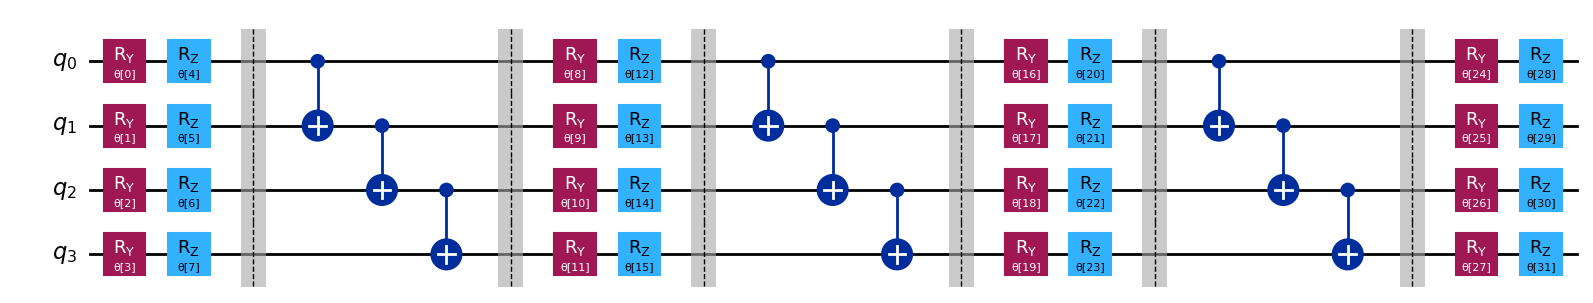

In [ ]:
ansatz.decompose().draw("mpl")

In [ ]:
# 5. 시뮬레이터 설정
print("\n[5단계] 양자 시뮬레이터 설정")
print("-" * 60)

backend = AerSimulator()
print(f"백엔드: {backend.name}")

# Estimator 설정 (Qiskit Primitives)
estimator = Estimator()


[5단계] 양자 시뮬레이터 설정
------------------------------------------------------------
백엔드: aer_simulator


In [ ]:
# 6. Optimizer 설정
print("\n[6단계] Classical Optimizer 설정")
print("-" * 60)

#optimizer = SLSQP(maxiter=4082)
#print(f"Optimizer: SLSQP \n 최대 반복 횟수: 4082")

# 1. 가장 많이 쓰이고 안정적인 최적 선택 (추천 1순위), 본 AER사용 예제에서는 수렴못함
#optimizer = SPSA(maxiter=1000, learning_rate=0.1, perturbation=0.05, second_order=True)

# 2. 노이즈가 심한 실제 양자 하드웨어에서 가장 강력한 선택, 본 AER사용 예제에서는 수렴않됨
#optimizer = SPSA(maxiter=2000, blocking=False, allowed_increase=0.1, learning_rate=0.05,  perturbation=0.01,  second_order=True, resamplings={1: 10, 50: 5, 100: 3})

# 3. 시뮬레이터에서 빠르고 정확하게 수렴시키고 싶을 때 (추천), 본 AER사용 예제에서 최상의 결과
#optimizer = COBYLA(maxiter=2000, tol=1e-7, rhobeg=1.0)

# 4. 시뮬레이터에서 가장 정확한 결과가 필요할 때
optimizer = L_BFGS_B(maxfun=5000, maxiter=3000, ftol=1e-12, iprint=1)

# 5. QAOA에서 가장 많이 검증된 설정
#optimizer = NFT(maxiter=500, maxfev=10000)

# 6. 최신 Qiskit에서 성능 좋은 Gradient 기반 (Simulator 전용)
#optimizer = P_BFGS(maxfun=10000, ftol=1e-9)


[6단계] Classical Optimizer 설정
------------------------------------------------------------


In [ ]:
# 7. VQE 실행
print("\n[7단계] VQE 알고리즘 실행")
print("-" * 60)
print("최적화 진행...")

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  print(eval_count," 단계: ", mean)
  cost_history.append(mean)
###def

# VQE 인스턴스 생성
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)

# VQE 실행
result = vqe.compute_minimum_eigenvalue(qubit_op)

print("최적화 완료!!!")


[7단계] VQE 알고리즘 실행
------------------------------------------------------------
최적화 진행...
1  단계:  -0.7735225421890303
2  단계:  -0.7735225425032882
3  단계:  -0.7735225437493776
4  단계:  -0.7735225434399489
5  단계:  -0.7735225424632577
6  단계:  -0.7735225421061311
7  단계:  -0.7735225420938413
8  단계:  -0.7735225420412071
9  단계:  -0.7735225418276699
10  단계:  -0.7735225445518163
11  단계:  -0.7735225427830413
12  단계:  -0.7735225428246433
13  단계:  -0.7735225429997852
14  단계:  -0.7735225426422767
15  단계:  -0.7735225418513948
16  단계:  -0.7735225416666537
17  단계:  -0.7735225412120178
18  단계:  -0.7735225423317094
19  단계:  -0.7735225421330032
20  단계:  -0.773522544069029
21  단계:  -0.7735225431821916
22  단계:  -0.7735225418792839
23  단계:  -0.7735225425601076
24  단계:  -0.773522542214418
25  단계:  -0.773522541597955
26  단계:  -0.7735225430299627
27  단계:  -0.7735225425236907
28  단계:  -0.7735225425968942
29  단계:  -0.7735225422181917
30  단계:  -0.773522542108735
31  단계:  -0.7735225422693255
32  단계:  -0.773522542264

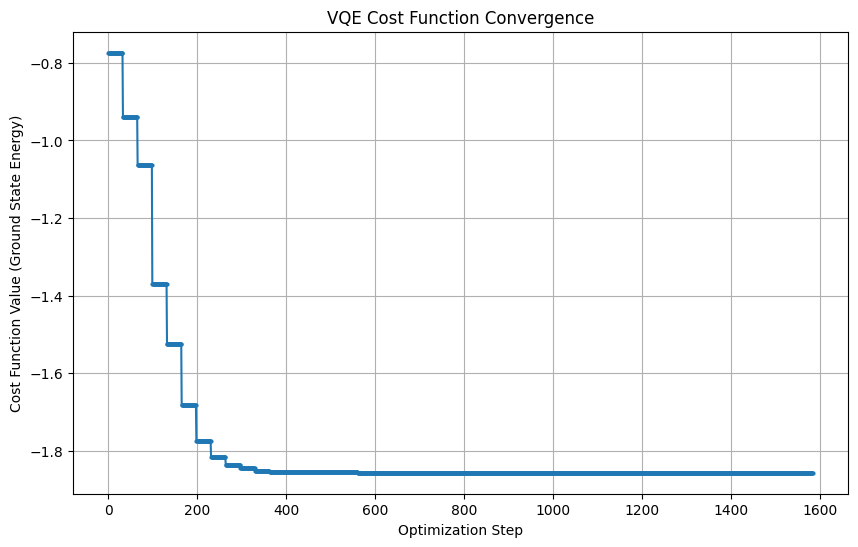

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

In [ ]:
# 8. 결과 출력
print("\n" + "=" * 60)
print("VQE 결과")
print("=" * 60)

print(f"\n최적 에너지 (VQE): {result.eigenvalue.real:.6f} Hartree")
print(f"최적 파라미터 개수: {len(result.optimal_point)}")
print(f"Optimizer 평가 횟수: {result.cost_function_evals}")


VQE 결과

최적 에너지 (VQE): -1.857265 Hartree
최적 파라미터 개수: 32
Optimizer 평가 횟수: 2000


In [ ]:
# 9. 정확한 해와 비교 (Classical 계산)
print("\n[비교] Classical Exact Eigensolver")
print("-" * 60)

from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

print(f"정확한 에너지: {exact_result.eigenvalue.real:.6f} Hartree")

# 오차 계산
error = abs(result.eigenvalue.real - exact_result.eigenvalue.real)
print(f"\n에너지 오차: {error:.6f} Hartree")
print(f"상대 오차: {(error / abs(exact_result.eigenvalue.real)) * 100:.4f}%")


[비교] Classical Exact Eigensolver
------------------------------------------------------------
정확한 에너지: -1.857275 Hartree

에너지 오차: 0.000010 Hartree
상대 오차: 0.0006%


In [ ]:
# 10. 추가 정보
print("\n" + "=" * 60)
print("추가 정보")
print("=" * 60)

# 에너지를 다른 단위로 변환 (Hartree to eV)
hartree_to_ev = 27.211386245988
vqe_energy_ev = result.eigenvalue.real * hartree_to_ev
exact_energy_ev = exact_result.eigenvalue.real * hartree_to_ev

print(f"\nVQE 에너지: {vqe_energy_ev:.6f} eV")
print(f"정확한 에너지: {exact_energy_ev:.6f} eV")

print("\n" + "=" * 60)
print("계산 완료!")
print("=" * 60)


추가 정보

VQE 에너지: -50.538745 eV
정확한 에너지: -50.539028 eV

계산 완료!
